In [4]:
import pandas as pd
import numpy as np
import geopandas as gpd
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

/home/mingyi/anaconda3/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [5]:
def loadData(file):
    data = pd.read_csv(file)
    print('Raw shape: ',data.shape)
    data['Date'] = pd.to_datetime(data.Date)
    print('Days: ',len(set(data.Date)))
    return data
def getTimeSeries(df,zones):
    zoneID = list(set(df.columns).intersection({'DOLocationID','PULocationID'}))[0]
    df = df.loc[df[zoneID].isin(zones)]
    table = pd.pivot_table(df, values='vehicle_count', index=['Date'],
                    columns=[zoneID,'Hour'], aggfunc=np.sum, fill_value=0)
#     table.columns = [i[1] for i in table.columns]
    missing_columns = [i for i in zones if i not in table.columns]
    for col in missing_columns:
        table[col] = 0
    table = table[sorted(table.columns)]
    return table

In [6]:
zone = gpd.read_file('../../Data/NYC Taxi Zones.geojson')
zones = zone['location_id'].unique()
zones = [int(i) for i in zones]

In [1]:
hub = 'JFK'
pca_comps = 6
dataDir = '/home/mingyi/Dropbox/UrbanTemporalNetworks/processedData/'
file = dataDir + hub + 'VehicleByHour2019fromHub.csv'
real = loadData(file)
real = getTimeSeries(real,zones)
real.head()

NameError: name 'loadData' is not defined

In [35]:
for hub in ['JFK','LGA','PENN']:
    for fileType in ['VehicleByHour2019fromHub.csv','VehicleByHour2019toHub.csv']:
        print(hub, fileType)
        if hub =='JFK' and fileType=='VehicleByHour2019fromHub.csv':
            pass
        else:
            file = dataDir + hub + fileType
            temp = loadData(file)
            temp = getTimeSeries(temp,zones)
            real = pd.concat([real,temp],axis=1)

JFK VehicleByHour2019fromHub.csv
JFK VehicleByHour2019toHub.csv
Raw shape:  (2303880, 4)
Days:  365
LGA VehicleByHour2019fromHub.csv
Raw shape:  (2295120, 4)
Days:  365
LGA VehicleByHour2019toHub.csv
Raw shape:  (2303880, 4)
Days:  365
PENN VehicleByHour2019fromHub.csv
Raw shape:  (2286360, 4)
Days:  365
PENN VehicleByHour2019toHub.csv
Raw shape:  (2295120, 4)
Days:  365


In [37]:
scaler = StandardScaler()
realS = scaler.fit_transform(real)
pca = PCA(n_components=365)
pca.fit(realS)
explained_variance = pca.explained_variance_ratio_

In [38]:
for i,j in enumerate(explained_variance.cumsum()):
    if j > 0.85:
        print(i)
        break

284


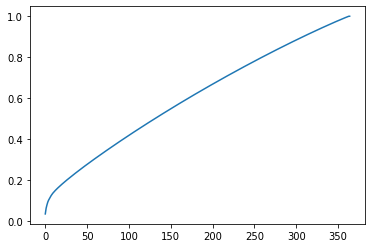

In [39]:
plt.plot(range(0,365),explained_variance.cumsum())

In [40]:
pca = PCA(n_components=284)
pc = pca.fit_transform(realS)

In [41]:
def GMMBIC(matrix):
    bic = []
    for ncomp in range(2,10):
        gm=GaussianMixture(n_components=ncomp,n_init=100,max_iter=1000,random_state=0)
        labels = gm.fit_predict(matrix)
        score = gm.bic(matrix)
        bic += [score]
#         print(ncomp,score)
#     print('------------------------')
    GMMComp = np.array(bic).argmin() + 2
#         GMMBIC = np.array(bic).min()
    print('GMM in %s component has the lowest BIC value'%GMMComp)
    return GMMComp

In [42]:
GMMBIC(pc)

GMM in 3 component has the lowest BIC value


3

In [ ]:
gm=GaussianMixture(n_components=3,n_init=100,max_iter=1000,random_state=0)
gm.fit(realS)
# scores = gm.score_samples(reallDate)

In [ ]:
cluster = pd.DataFrame(gm.predict_proba(realS),columns=['1','2','3'])
cluster['Date'] = real.index
cluster['Date'] = pd.to_datetime(cluster['Date'])
cluster['DOW'] = pd.to_datetime(cluster['Date']).dt.dayofweek
holidays = pd.read_csv('2019Holidays.csv',sep='\t')
holidays['Date'] = pd.to_datetime(holidays['Date'])
cluster = cluster.merge(holidays,how='left')
cluster = cluster.fillna(0)

In [99]:
cluster.groupby('3').count()

,1,2,Date,DOW,Federal holiday,Day of the week
3,,,,,,
0.0,245,245,245,245,245,245
1.0,120,120,120,120,120,120


In [102]:
clusterNo = '3'
len(cluster.loc[(cluster[clusterNo]==1)&(cluster['DOW']==5)])/len(cluster.loc[(cluster[clusterNo]==1)])

0.3

In [103]:
len(cluster.loc[(cluster[clusterNo]==1)&(cluster['DOW']==6)])/len(cluster.loc[(cluster[clusterNo]==1)])

0.016666666666666666

In [104]:
len(cluster.loc[(cluster[clusterNo]==1)&(cluster['DOW']<5)])/len(cluster.loc[(cluster[clusterNo]==1)])

0.6833333333333333

In [105]:
len(cluster.loc[(cluster[clusterNo]==1)&(cluster['Federal holiday']!=0)])

3

In [106]:
# realDate = realDate.reset_index()
ridership = pd.DataFrame(real.reset_index().sum(axis=1))
ridership['date'] = real.index
ridership.loc[ridership['date'].isin(cluster.loc[(cluster[clusterNo]==1)]['Date'])].sum().sum()/len(cluster.loc[(cluster[clusterNo]==1)])

14894.283333333333

In [108]:
cluster.to_csv('cluster.csv',index=False)